# Empirically testing the normality conjecture

In Hu & Lu, they show that when the covariates $z_i$ are Gaussian, the features $x_i$ are generated by a random features model, and the labels $y_i$ are given by 

$$y_i = \psi(\langle \theta^*, z_i \rangle),$$

then the features $x_i$ are asymptotically Gaussian and the joint distribution of $y_i$ with any one-dimensional projection of the features $x_i$ is jointly Gaussian.

Here, we empirically explore whether this normality holds more generally (by visualizing the distributions and running the D’Agostino-Pearson test). If so, there is hope that a similar proof technique can be used to show universality under more general assumptions on the response function.

For now, the loss is mean-squared error and the model being fit is a (mispecified) linear model [i.e., $\ell(x, y) = (x - y)^2$ ]

## Hu & Lu Setting

In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from universality_erm_utils import *
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def test_normality(x, title=None):
    if title:
        print(title)
        indent = '   '
    else:
        indent = ''
    if len(np.shape(x))==1:
        print(f'{indent}D\'Agostino-Pearson test: {scipy.stats.normaltest(x).pvalue}')
    print(f'{indent}Shapiro-Wilk test: {scipy.stats.shapiro(x).pvalue}')
    print()

### $\psi: x \mapsto x, \sigma_{RF}: x \mapsto \tanh(x)$

In [2]:
n = 6000
n_train = 1200
gamma = 1.5
eta = 0.5
d = 200
p = int(n_train * gamma)
nu = 0.5

psi = lambda x: x
rf_activation = np.tanh

z_mean = np.array([0]*d)
z_cov = np.identity(d)
Z = np.random.multivariate_normal(mean=z_mean, cov=z_cov, size=n)

## generate unknown model parameter
beta_star = np.random.normal(loc=0, scale=1, size=(d,1))
beta_star /= np.linalg.norm(beta_star, ord=2)

## generate response
epsilon = np.random.normal(loc=0, scale=nu, size=(n,1))
y = np.squeeze(psi(Z@beta_star + epsilon))

rfmodel_phi, W = get_rfmodel(d, p, rf_activation)

X = rfmodel_phi(Z)

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

#### $\theta \sim \text{Unif}(\mathbb{S}^{p-1})$

In [3]:
theta = np.random.normal(loc=0, scale=1, size=(p,1))
theta /= np.linalg.norm(theta, ord=2)

proj_X = np.squeeze(np.dot(X_test, theta))

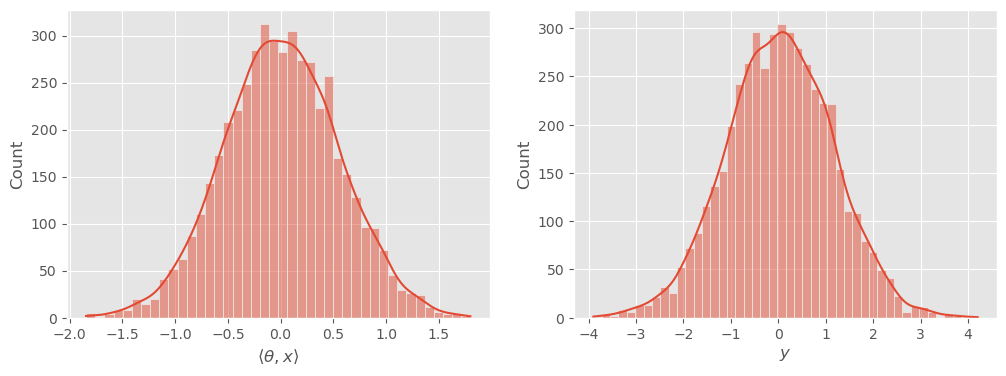

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [5]:
test_normality(proj_X, title='proj X')
test_normality(y_test, title='y')

proj X
   D'Agostino-Pearson test: 0.9741623741154924
   Shapiro-Wilk test: 0.7038919925689697

y
   D'Agostino-Pearson test: 0.3221588008691278
   Shapiro-Wilk test: 0.4324118494987488



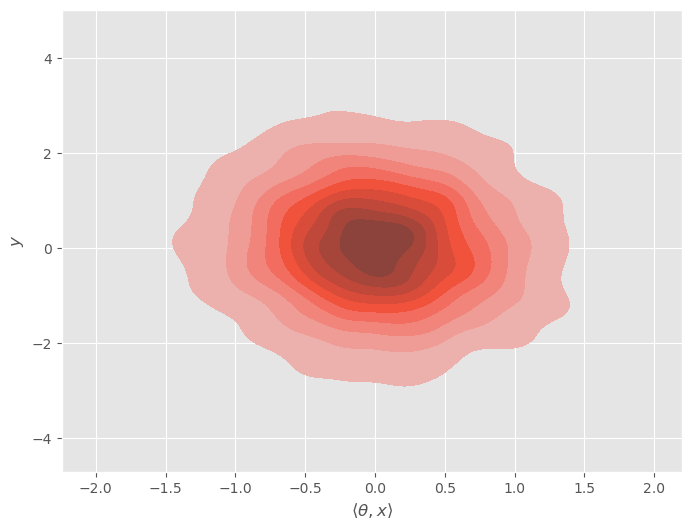

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

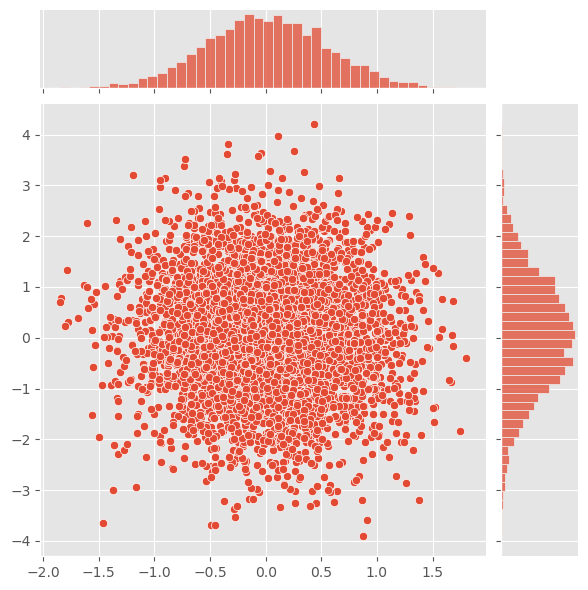

In [7]:
g = sns.jointplot(x=proj_X, y=y_test)

In [8]:
test_normality(np.stack([proj_X, y_test], axis=1), title='joint (proj X, y)')

joint (proj X, y)
   Shapiro-Wilk test: 2.2853604721183925e-27



/gpfs/gibbs/project/lafferty/ma2393/conda_envs/relml/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### $\theta = \theta^*$ (mse-minimizer)

In [9]:
from sklearn.linear_model import LinearRegression
theta = LinearRegression(fit_intercept=False).fit(X_train, y_train).coef_
proj_X = np.squeeze(np.dot(X_test, theta))

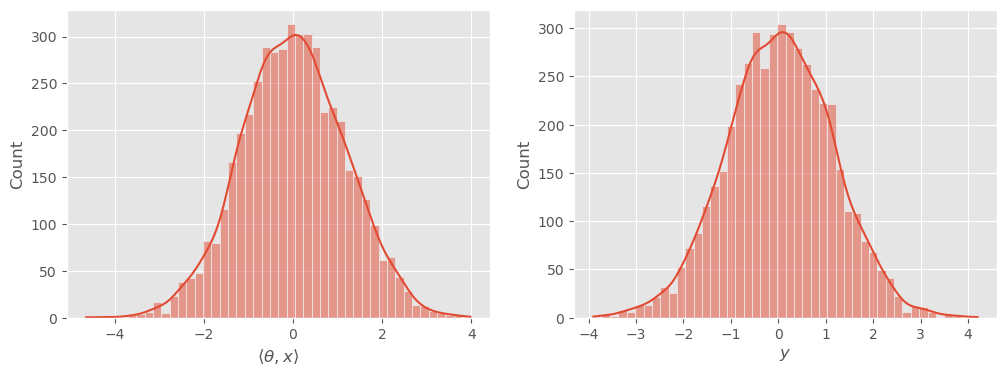

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [11]:
test_normality(proj_X, title='proj X')
test_normality(y_test, title='y')

proj X
   D'Agostino-Pearson test: 0.9793010030328306
   Shapiro-Wilk test: 0.45192256569862366

y
   D'Agostino-Pearson test: 0.3221588008691278
   Shapiro-Wilk test: 0.4324118494987488



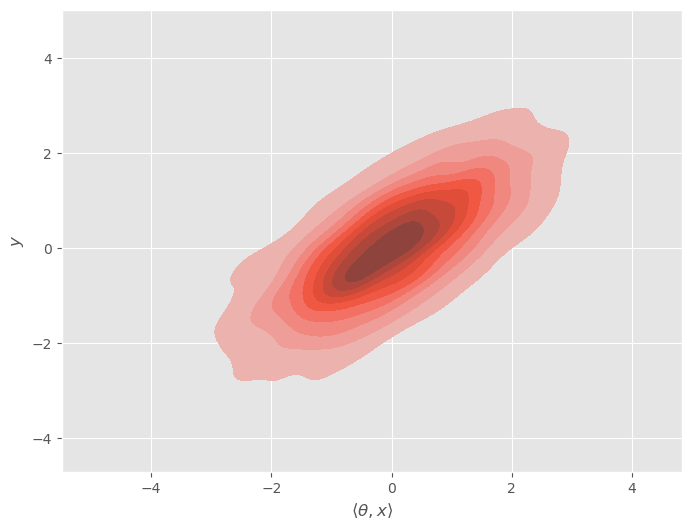

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

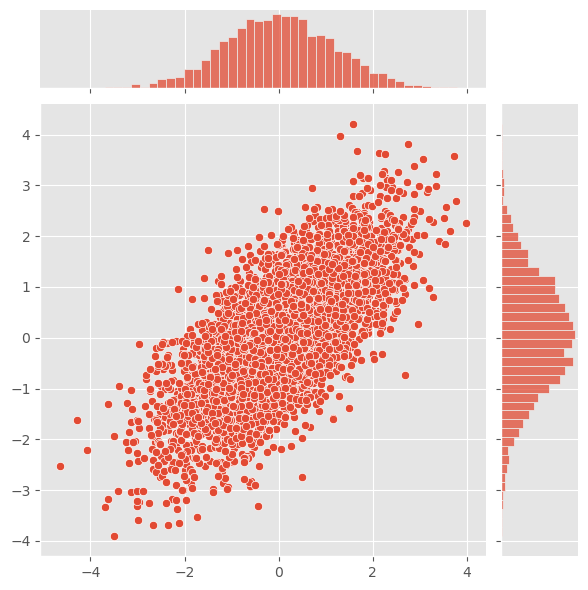

In [13]:
g = sns.jointplot(x=proj_X, y=y_test)

In [14]:
test_normality(np.stack([proj_X, y_test], axis=1), title='joint (proj X, y)')

joint (proj X, y)
   Shapiro-Wilk test: 0.511432945728302



/gpfs/gibbs/project/lafferty/ma2393/conda_envs/relml/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## with NeurNet Response Function

### $y_i = \mathrm{NeurNet}(z) + \varepsilon_i$, (architecture: $128-256-128-1$); $\sigma_{RF}: x \mapsto \tanh(x)$

In [15]:
response_nn_layers = [128, 256, 128]
response_nn_activation = 'tanh'

n = 6000
n_train = 1200
gamma = 1.5
eta = 0.5
# d = int(n_train * eta)
d = 200
p = int(n_train * gamma)
nu = 0.5

rf_activation = np.tanh

z_mean = np.array([0]*d)
z_cov = np.identity(d)
Z = np.random.multivariate_normal(mean=z_mean, cov=z_cov, size=n)

# ground truth response function to be predicted: y = NN(z)
# generate random neural network response function
response_nn = tf.keras.Sequential(
    [
    tf.keras.layers.Dense(n_neurons, activation=response_nn_activation)
    for n_neurons in response_nn_layers] \
    + [tf.keras.layers.Dense(1, activation='linear')])

epsilon = np.random.normal(loc=0, scale=nu, size=(n,1))
y = np.squeeze(response_nn(Z) + epsilon)

rfmodel_phi, W = get_rfmodel(d, p, rf_activation)

X = rfmodel_phi(Z)

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

#### $\theta \sim \text{Unif}(\mathbb{S}^{p-1})$

In [16]:
theta = np.random.normal(loc=0, scale=1, size=(p,1))
theta /= np.linalg.norm(theta, ord=2)

proj_X = np.squeeze(np.dot(X_test, theta))

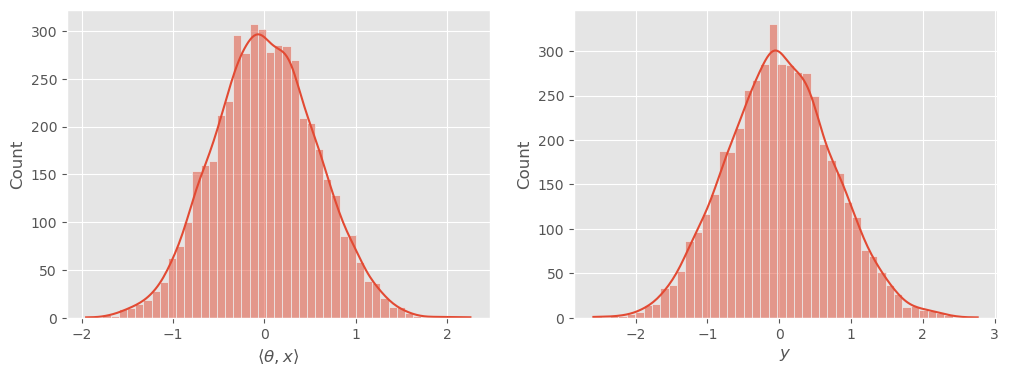

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [18]:
test_normality(proj_X, title='proj X')
test_normality(y_test, title='y')

proj X
   D'Agostino-Pearson test: 0.1895090593687753
   Shapiro-Wilk test: 0.42341524362564087

y
   D'Agostino-Pearson test: 0.23515821152120486
   Shapiro-Wilk test: 0.5496710538864136



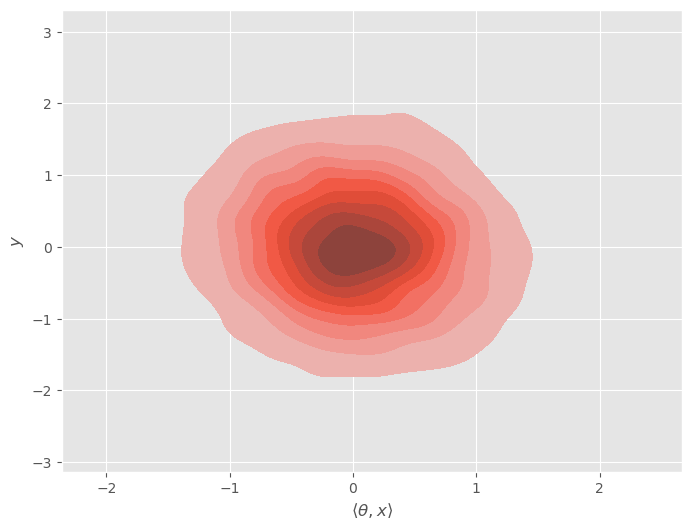

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

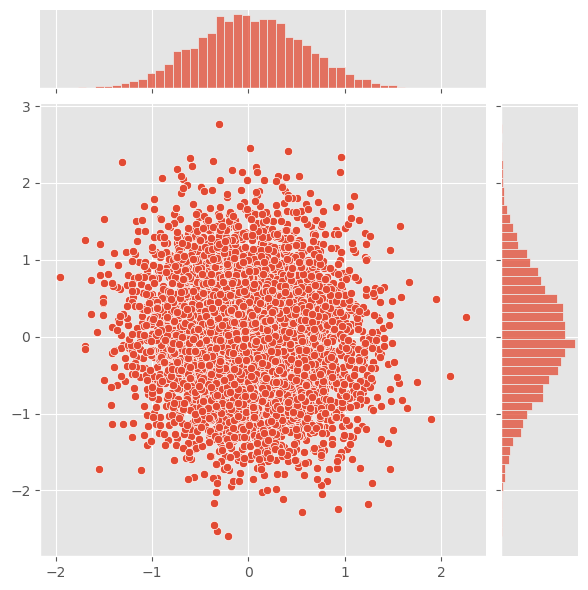

In [20]:
g = sns.jointplot(x=proj_X, y=y_test)

In [21]:
test_normality(np.stack([proj_X, y_test], axis=1), title='joint (proj X, y)')

joint (proj X, y)
   Shapiro-Wilk test: 0.024704212322831154



/gpfs/gibbs/project/lafferty/ma2393/conda_envs/relml/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### $\theta = \theta^*$ (mse-minimizer)

In [22]:
from sklearn.linear_model import LinearRegression
theta = LinearRegression(fit_intercept=False).fit(X_train, y_train).coef_
proj_X = np.squeeze(np.dot(X_test, theta))

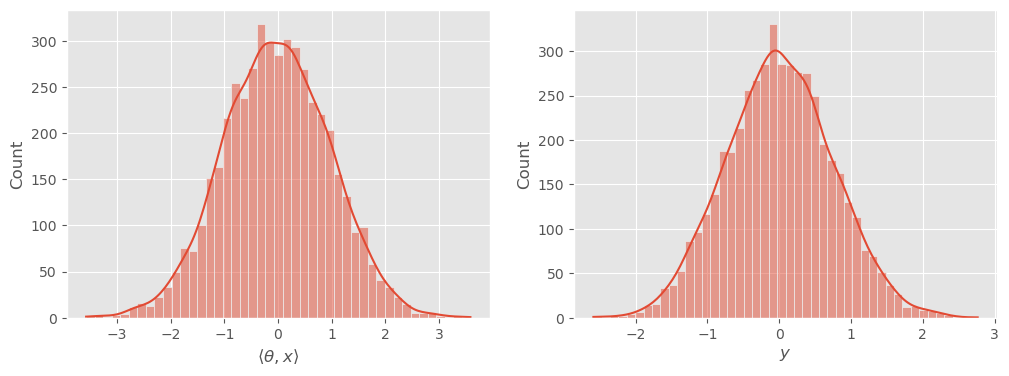

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
g = sns.histplot(proj_X, kde=True, ax=ax1);
g.set(xlabel='$\\langle \\theta, x \\rangle$');
g = sns.histplot(y_test, kde=True, ax=ax2);
g.set(xlabel='$y$');

In [24]:
test_normality(proj_X, title='proj X')
test_normality(y_test, title='y')

proj X
   D'Agostino-Pearson test: 0.9217047459447013
   Shapiro-Wilk test: 0.8107355237007141

y
   D'Agostino-Pearson test: 0.23515821152120486
   Shapiro-Wilk test: 0.5496710538864136



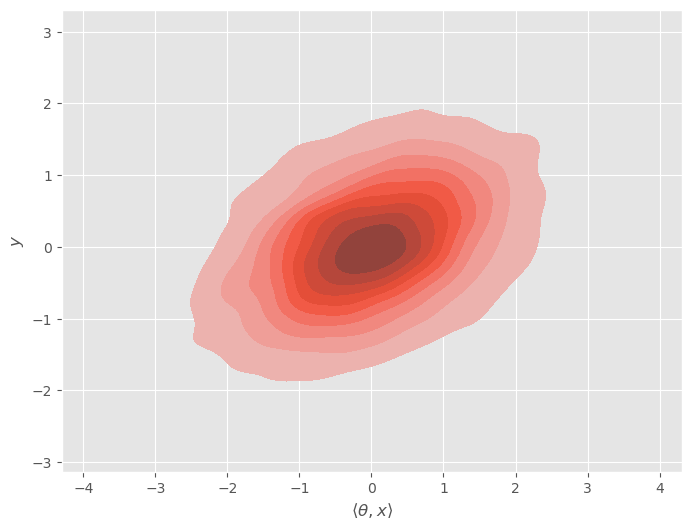

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.kdeplot(x=proj_X, y=y_test, ax=ax, fill=True);
fig.set(xlabel='$\\langle \\theta, x \\rangle$', ylabel='$y$');

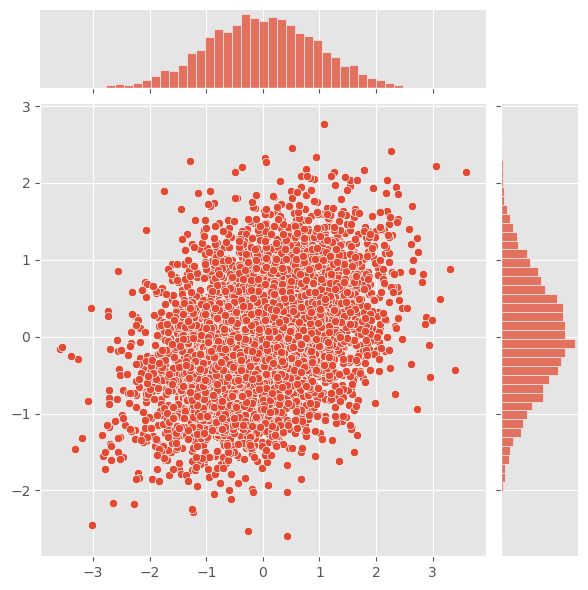

In [26]:
g = sns.jointplot(x=proj_X, y=y_test)

In [27]:
test_normality(np.stack([proj_X, y_test], axis=1), title='joint (proj X, y)')

joint (proj X, y)
   Shapiro-Wilk test: 0.0033222322817891836



/gpfs/gibbs/project/lafferty/ma2393/conda_envs/relml/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
